In [1]:
import pandas as pd

# Charger le CSV
df = pd.read_csv("data/dataset_selection.csv")

# Aperçu du dataset
print("Aperçu du dataset :")
print(df.head())

print("\nInformations générales :")
print(df.info())


Aperçu du dataset :
                                                path     label
0  E:\mémoire\Memoire\data\glaucome\ACRIMA\ACRIMA...  glaucome
1  E:\mémoire\Memoire\data\glaucome\ACRIMA\ACRIMA...  glaucome
2  E:\mémoire\Memoire\data\glaucome\ACRIMA\ACRIMA...  glaucome
3  E:\mémoire\Memoire\data\glaucome\ACRIMA\ACRIMA...  glaucome
4  E:\mémoire\Memoire\data\glaucome\ACRIMA\ACRIMA...  glaucome

Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9547 entries, 0 to 9546
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9547 non-null   object
 1   label   9547 non-null   object
dtypes: object(2)
memory usage: 149.3+ KB
None


In [2]:
print(f"Nombre total d'images : {len(df)}")
print(f"Nombre de colonnes : {df.shape[1]}")


Nombre total d'images : 9547
Nombre de colonnes : 2


In [3]:
# Compter le nombre d'images par label
class_counts = df['label'].value_counts()

print("\nRépartition des labels :")
print(class_counts)

# Pourcentage par label
class_percent = df['label'].value_counts(normalize=True) * 100
print("\nPourcentage par label :")
print(class_percent.round(2))



Répartition des labels :
label
glaucome    2517
diabete     2500
normaux     2484
mda         2046
Name: count, dtype: int64

Pourcentage par label :
label
glaucome    26.36
diabete     26.19
normaux     26.02
mda         21.43
Name: proportion, dtype: float64


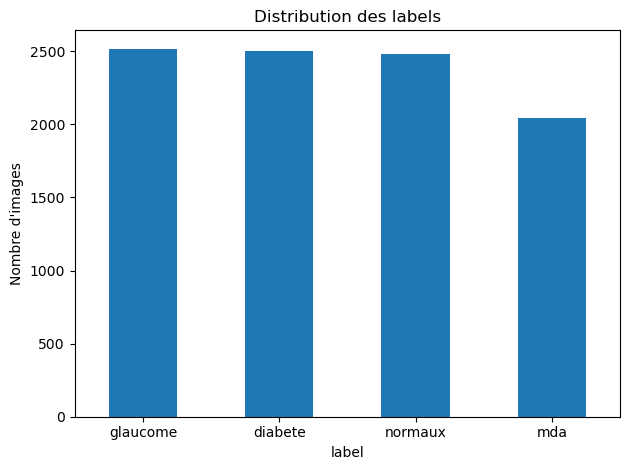

In [4]:
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.title("Distribution des labels")
plt.xlabel("label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
for classe in df['label'].unique():
    print(f"\nExemples pour la classe '{classe}' :")
    print(df[df['label'] == classe]['path'].head(3).tolist())



Exemples pour la classe 'glaucome' :
['E:\\mémoire\\Memoire\\data\\glaucome\\ACRIMA\\ACRIMA\\NOT PARTITIONED\\glaucoma\\Im310_g_ACRIMA.jpg', 'E:\\mémoire\\Memoire\\data\\glaucome\\ACRIMA\\ACRIMA\\NOT PARTITIONED\\glaucoma\\Im311_g_ACRIMA.jpg', 'E:\\mémoire\\Memoire\\data\\glaucome\\ACRIMA\\ACRIMA\\NOT PARTITIONED\\glaucoma\\Im312_g_ACRIMA.jpg']

Exemples pour la classe 'mda' :
['E:\\mémoire\\Memoire\\data\\mda\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Dataset\\train\\amd\\1012.jpg', 'E:\\mémoire\\Memoire\\data\\mda\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Dataset\\train\\amd\\1013.jpg', 'E:\\mémoire\\Memoire\\data\\mda\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)




print("Tailles des splits :")
print(f"Train : {len(df_train)}")
print(f"Test : {len(df_test)}")


Tailles des splits :
Train : 7637
Test : 1910


In [7]:
def show_distribution(name, data):
    print(f"\n{name}")
    print(data['label'].value_counts(normalize=True).round(3))

show_distribution("Train", df_train)
show_distribution("Test", df_test)



Train
label
glaucome    0.264
diabete     0.262
normaux     0.260
mda         0.214
Name: proportion, dtype: float64

Test
label
glaucome    0.264
diabete     0.262
normaux     0.260
mda         0.214
Name: proportion, dtype: float64


In [8]:
import cv2
import numpy as np
import os

def augment_image(img):
    aug_images = []

    # rotation
    for angle in [-15, 15]:
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        aug_images.append(cv2.warpAffine(img, M, (w, h)))

    # flip
    aug_images.append(cv2.flip(img, 1))

    return aug_images


extraction de caracteristique


In [9]:
from skimage.feature import hog

def extract_hog(image):
    image = cv2.resize(image, (128, 128))
    features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )
    return features


In [10]:
from PIL import Image
import numpy as np

def load_image_gray(path):
    img = Image.open(path).convert("L")  # grayscale
    return np.array(img)



In [11]:
X_train, y_train = [], []

for _, row in df_train.iterrows():
    img = load_image_gray(row['path'])

    # image originale
    X_train.append(extract_hog(img))
    y_train.append(row['label'])

    # data augmentation
    for aug in augment_image(img):
        X_train.append(extract_hog(aug))
        y_train.append(row['label'])

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Train :", X_train.shape, y_train.shape)


Train : (30548, 8100) (30548,)


In [12]:
X_test, y_test = [], []

for _, row in df_test.iterrows():
    img = load_image_gray(row['path'])
    X_test.append(extract_hog(img))
    y_test.append(row['label'])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Test :", X_test.shape, y_test.shape)


Test : (1910, 8100) (1910,)


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(
    max_iter=5000,
    random_state=42
)

param_grid = [
    # lbfgs : seulement l2 (multiclass OK)
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "tol": [1e-4, 1e-3, 1e-2],
        "max_iter": [2000, 5000]
    }
]

grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=1,
    verbose=2
)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time=  46.6s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time= 1.1min
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time=  49.9s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time= 1.1min
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time=  45.0s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  15.6s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  15.6s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  15.4s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  16.2s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  16.2s
[CV] END C=0.001, max_iter=2000, penalty=l2

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"[{'C': [0.001, 0.01, ...], 'max_iter': [2000, 5000], 'penalty': ['l2'], 'solver': ['lbfgs'], ...}]"
,scoring,'f1_macro'
,n_jobs,1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [15]:
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score CV (F1-macro) :", grid.best_score_)
best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_test)


Meilleurs paramètres : {'C': 0.001, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}
Meilleur score CV (F1-macro) : 0.9228274862278758


In [16]:
from sklearn.metrics import classification_report

print("\n===== Logistic Regression (Best Model) =====")
print(classification_report(y_test, y_pred))



===== Logistic Regression (Best Model) =====
              precision    recall  f1-score   support

     diabete       0.97      0.99      0.98       500
    glaucome       0.99      1.00      1.00       504
         mda       0.91      0.82      0.86       409
     normaux       0.88      0.93      0.91       497

    accuracy                           0.94      1910
   macro avg       0.94      0.94      0.94      1910
weighted avg       0.94      0.94      0.94      1910



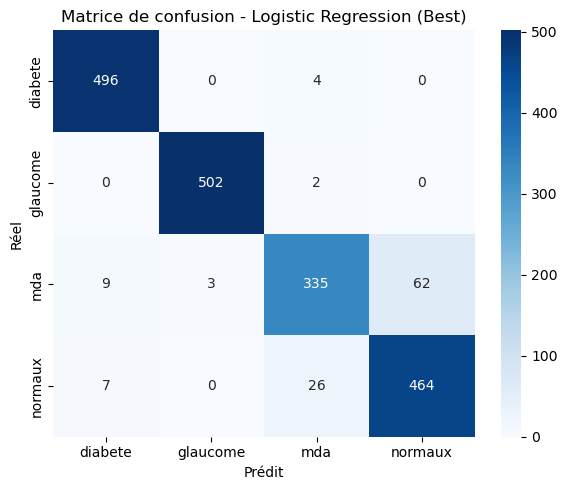

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=best_lr.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=best_lr.classes_,
    yticklabels=best_lr.classes_
)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Logistic Regression (Best)")
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

acc = accuracy_score(y_test, y_pred)

prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec_macro  = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro   = f1_score(y_test, y_pred, average='macro', zero_division=0)

prec_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec_weighted  = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_weighted   = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Precision macro: {prec_macro:.4f} | weighted: {prec_weighted:.4f}")
print(f"Recall macro:    {rec_macro:.4f} | weighted: {rec_weighted:.4f}")
print(f"F1 macro:        {f1_macro:.4f} | weighted: {f1_weighted:.4f}")


Accuracy: 0.9408
Precision macro: 0.9394 | weighted: 0.9409
Recall macro:    0.9352 | weighted: 0.9408
F1 macro:        0.9365 | weighted: 0.9401


In [19]:
specificities = []

for i in range(len(best_lr.classes_)):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)

    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    specificities.append(spec)

spec_macro = np.mean(specificities)

print(f"Specificity macro: {spec_macro:.4f}")
print("Specificity par classe:")
print(dict(zip(best_lr.classes_, specificities)))


Specificity macro: 0.9803
Specificity par classe:
{'diabete': 0.9886524822695035, 'glaucome': 0.9978662873399715, 'mda': 0.9786808794137242, 'normaux': 0.9561217268223637}


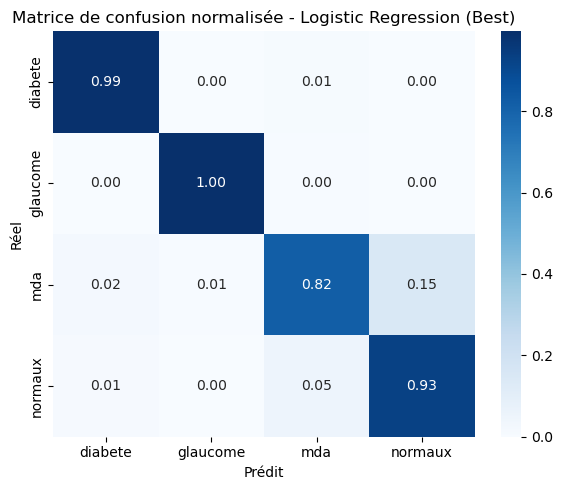

In [20]:
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=best_lr.classes_,
    yticklabels=best_lr.classes_
)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion normalisée - Logistic Regression (Best)")
plt.tight_layout()
plt.show()


In [21]:
import joblib

joblib.dump(best_lr, "logistic_regression_best.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Meilleur modèle et scaler sauvegardés 💾")


Meilleur modèle et scaler sauvegardés 💾
